# Modèle Stochastic Gradient Descent Regressor

In [1]:
import pandas as pd
import numpy as np
import os 
import shap
import importlib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from joblib import dump, load
import pickle

%matplotlib inline

def modelAlreadyTrain(filename):
    return os.path.isfile('../models/' + filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Récupération des données 
### Création des jeux de données d'entrainement et des jeux de données de test

In [2]:
df=pd.read_csv('../Data/processed/Co2_final.csv')
X = df.drop(columns=['Ewltp (g/km)', 'ID'])
y = df['Ewltp (g/km)']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


> Mise à l'echelle des différentes valeurs

In [3]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Entrainement du modèle

> Utilisation d'une grid search pour trouver le meilleur paramétrage
>
> Note : Pour des raisons de fludité on va réduire le jeux de données en s'assurant de garder un échantillonnage représentatif des données initiales

In [4]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm
import numpy as np
import sys

def TrainModelSGDRegressor(X, y, sample_size=500_000):
    # Discrétiser y en bins pour stratification
    bins = np.linspace(y.min(), y.max(), num=10)
    y_binned = np.digitize(y, bins)

    # Réduction du jeu de données
    if X.shape[0] > sample_size:
        X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42, stratify=y_binned)
        print(f"Dataset réduit à {sample_size} lignes pour l'entraînement.")

    # Paramètres pour GridSearch
    param_grid = {
        'loss': ['squared_error', 'epsilon_insensitive'],  # Fonctions de perte
        'penalty': ['l2', 'l1'],  # Régularisation
        'alpha': [ 0.001, 0.01],  # Taux de régularisation
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Stratégie de LR
        'eta0': [0.1, 1.0],  # Taux d'apprentissage initial
        'max_iter': [1000],  # Nombre maximal d'itérations
        'tol': [1e-2]  # Tolérance pour la convergence
    }

    # Calcul du nombre total de combinaisons
    total_combinations = (
        len(param_grid['loss']) *
        len(param_grid['penalty']) *
        len(param_grid['alpha']) *
        len(param_grid['learning_rate']) *
        len(param_grid['eta0']) *
        len(param_grid['max_iter']) *
        len(param_grid['tol']) *
        3  # cv=3
    )

    # Initialisation de tqdm pour afficher la progression
    pbar = tqdm(total=total_combinations, desc="GridSearch Progress", position=0, leave=True)

    class TqdmWriter:
        """Redirige les logs de verbose vers tqdm."""
        def write(self, message):
            if message.strip():  # Éviter les lignes vides
                pbar.update(1)

        def flush(self):
            pass

    # Création de GridSearch avec verbose redirigé vers tqdm
    grid_search = GridSearchCV(
        SGDRegressor(random_state=42),
        param_grid,
        cv=3,
        verbose=3,  # Affiche les logs pour chaque tâche
        n_jobs=1
    )

    # Rediriger stdout pour capturer les logs
    old_stdout = sys.stdout
    sys.stdout = TqdmWriter()

    try:
        grid_search.fit(X, y)
    finally:
        sys.stdout = old_stdout  # Restaurer stdout
        pbar.close()

    print("Meilleurs paramètres trouvés :", grid_search.best_params_)
    return grid_search



# Meilleur parametres trouvées 
""""
{'alpha': 0.001, 
'eta0': 0.1, 
'learning_rate': 'adaptive', 
'loss': 'squared_error', 
'max_iter': 1000, 
'penalty': 'l1', 
'tol': 0.01}
"""


'"\n{\'alpha\': 0.001, \n\'eta0\': 0.1, \n\'learning_rate\': \'adaptive\', \n\'loss\': \'squared_error\', \n\'max_iter\': 1000, \n\'penalty\': \'l1\', \n\'tol\': 0.01}\n'

> Une fois le paramétrage optimun trouvé suite à la recherche GridSearchCV, on s'assure de sauvegarder le modèle pour éviter de lourds entraînements

In [5]:
if modelAlreadyTrain('SGDRegressor.pkl'):
    trainningModel = loadPickleModel('SGDRegressor.pkl')
else :
    #trainningModel = TrainModelSGDRegressor(X_train, y_train)
    trainningModel = SGDRegressor(  alpha = 0.001, 
                                    eta0 = 0.1, 
                                    learning_rate = 'adaptive', 
                                    loss = 'squared_error', 
                                    max_iter = 1000, 
                                    penalty = 'l1', 
                                    tol = 0.01)
    
    trainningModel.fit(X_train, y_train)
    savePickleModel(trainningModel, 'SGDRegressor.pkl')

### Résultats du modèle
> Calcul de du RMSE et du score R² permettant d'évaluer le modèle

In [6]:
from RegressorModel import RegressorModel
Model = RegressorModel('SDGModel', 
                          trainningModel, 
                          X_train, 
                          X_test, 
                          y_train, 
                          y_test, 
                          X.columns)

Model.predictModel()
Model.calcScore()
Model.displayScore()

RMSE Jeux d entrainement : 2.5514493786248167
RMSE Jeux de test : 2.511162870832678
Score du modèle train (R²) 0.9970562622645246
Score du modèle test (R²) 0.9971410733622893


> Sauvegarde des scores du modèle

In [12]:
Model.writeResults()

### Représentation graphique des résultats du modèle
> Affichage graphique des résultats en représentant sur l'axe y les valeurs prédites et sur l'axe x la valeur rééle
>
> Plus les résultats sont concentrés sur la diagonale plus le modèle est performant

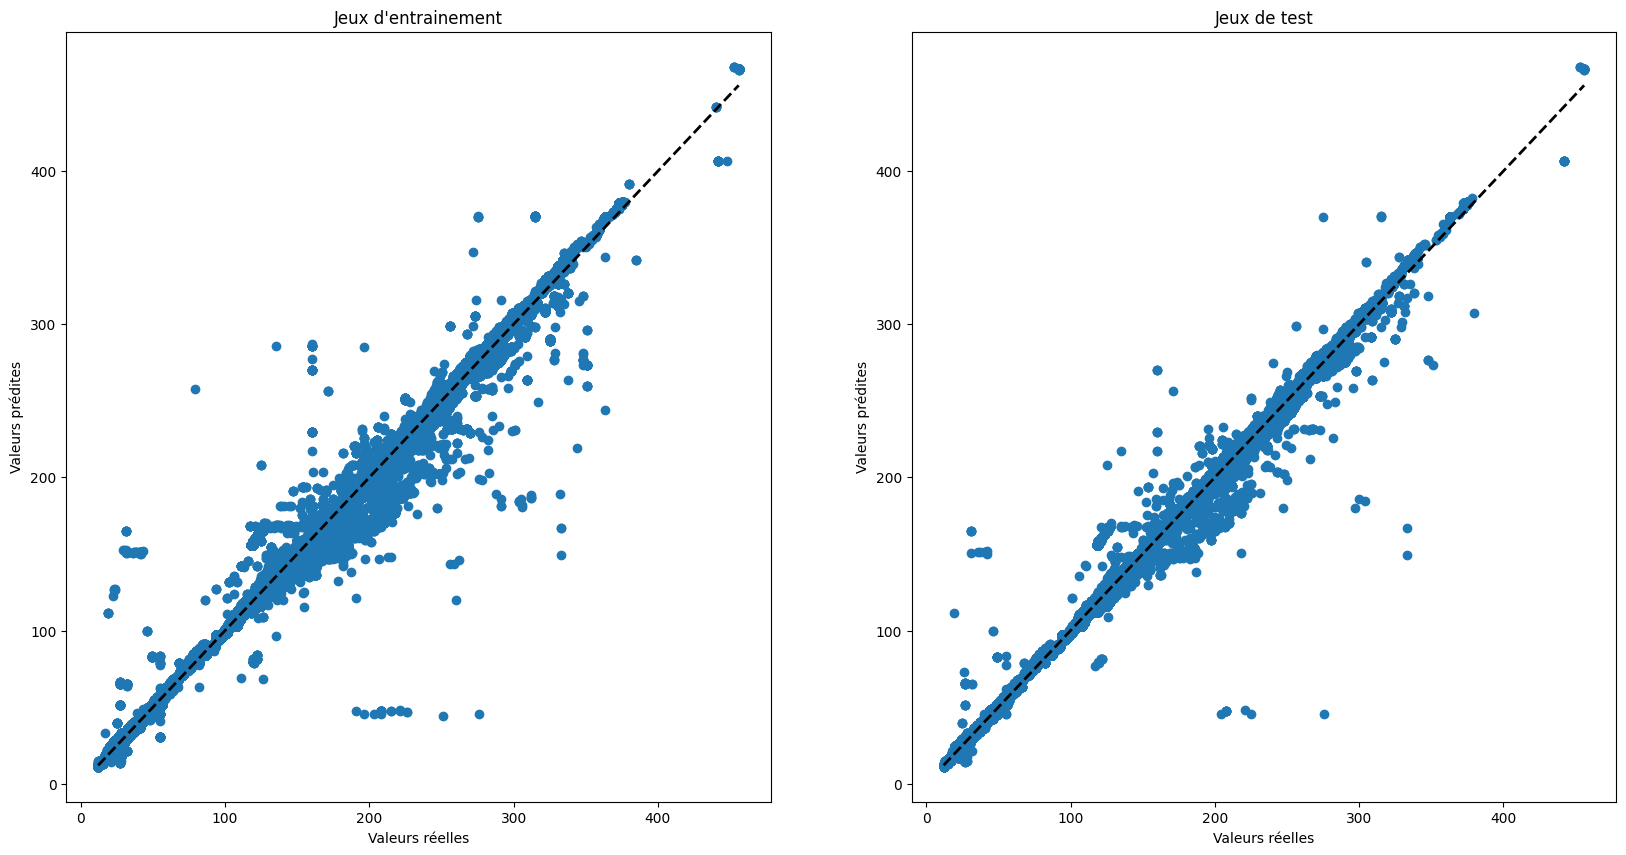

In [8]:
Model.displayGraphResultVsReel()

> Affichage de la distribution de la différence entre la valeur prédite et la valeur réele
>
> Plus la distribution est centrée sur zéro et plus le modèle est performant

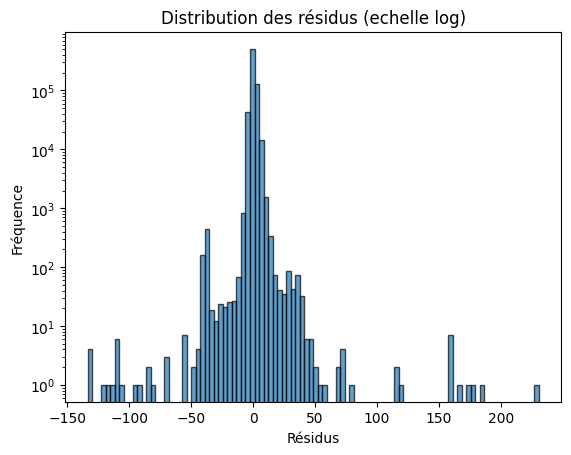

In [7]:
Model.displayDistributionOfResidue(True)

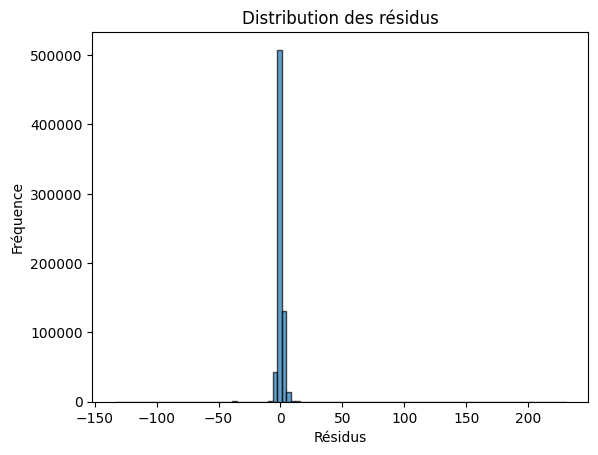

In [10]:
Model.displayDistributionOfResidue(False)

### Interpretabilité du modèle
> Les temps de calcul de l'analyse SHAP, nous oblige à limiter le nombre de valeurs examinées

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


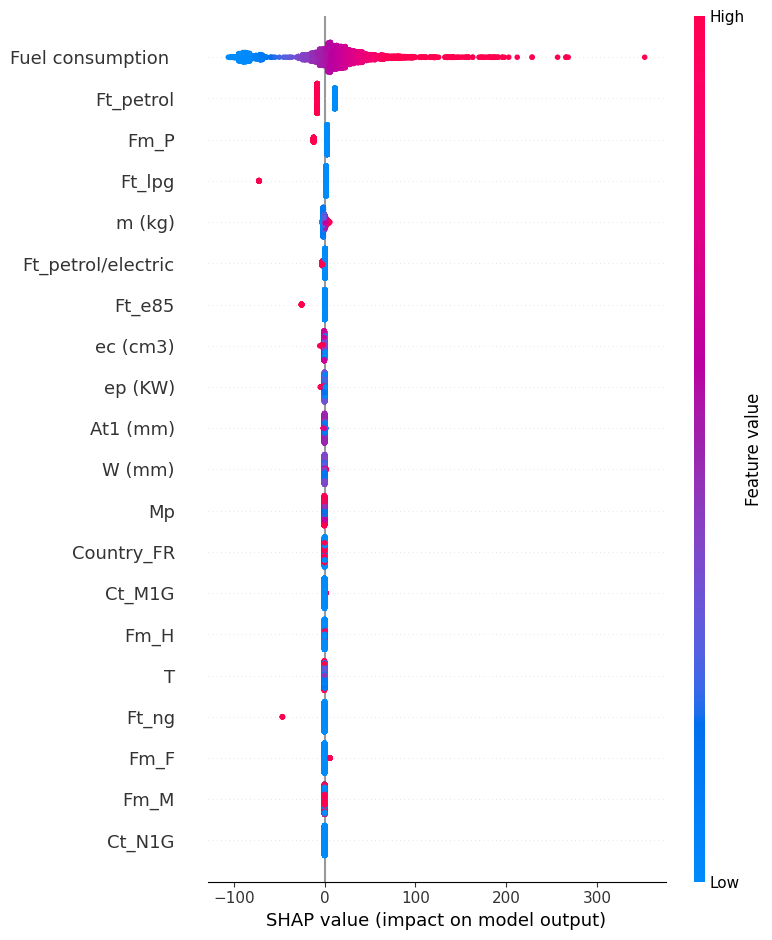

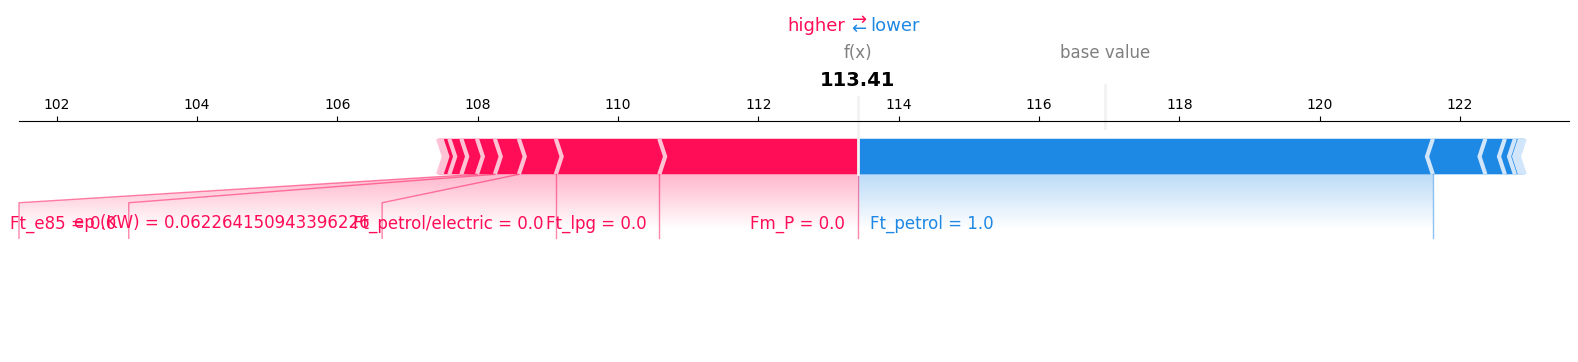

In [11]:
Model.displayShap(5000)